Treino: 1161 linhas
Teste: 65 linhas (2025-07-02 → 2025-09-30)

🔹 KNN
Acurácia no último mês: 43.1%
Classification Report (Último mês):
              precision    recall  f1-score   support

           0       0.45      0.55      0.49        33
           1       0.40      0.31      0.35        32

    accuracy                           0.43        65
   macro avg       0.43      0.43      0.42        65
weighted avg       0.43      0.43      0.42        65


🔹 SVM
Acurácia no último mês: 52.3%
Classification Report (Último mês):
              precision    recall  f1-score   support

           0       0.52      0.82      0.64        33
           1       0.54      0.22      0.31        32

    accuracy                           0.52        65
   macro avg       0.53      0.52      0.47        65
weighted avg       0.53      0.52      0.48        65


🔹 Random Forest
Acurácia no último mês: 47.7%
Classification Report (Último mês):
              precision    recall  f1-score   support


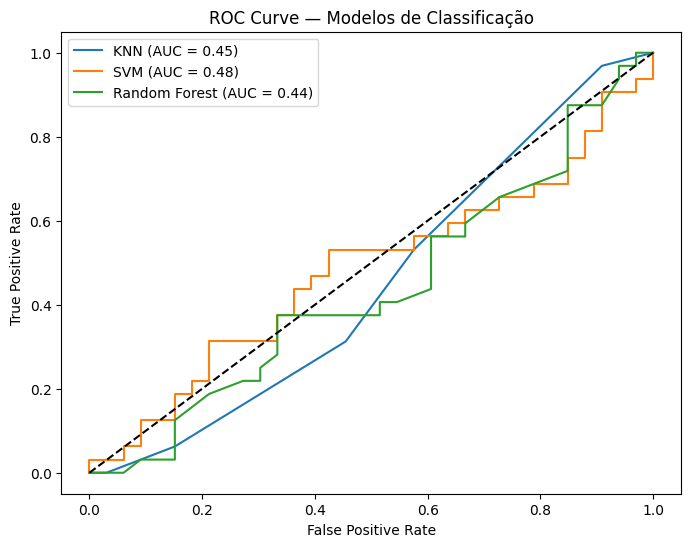


🔮 Previsão para o próximo dia:
O Ibovespa deve cair 📉


In [20]:
# ==========================================================
# PROJETO: Previsão de Movimentos do Ibovespa (versão otimizada)
# Pós-graduação em Data Analytics — FIAP
# ==========================================================

# 🔹 Importação das bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

# ==========================================================
# 1️⃣ LEITURA E LIMPEZA DOS DADOS
# ==========================================================
file_path = r"C:\Users\vinic\OneDrive\Área de Trabalho\Vinicius\Data Analytics\Tech Challenge\Fase 02\TechChallengeFase02\Dados Históricos - Ibovespa.xlsx"
df = pd.read_excel(file_path)
df.columns = ["Date", "Price", "Open", "High", "Low", "Vol", "Change"]
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df = df.sort_values("Date").reset_index(drop=True)

# Função para converter volumes
def parse_volume(v):
    v = str(v).replace(",", "").strip()
    if v.endswith("M"):
        return float(v[:-1]) * 1e6
    elif v.endswith("B"):
        return float(v[:-1]) * 1e9
    elif v.isdigit():
        return float(v)
    else:
        return np.nan

df["Vol"] = df["Vol"].apply(parse_volume)
df["Change"] = df["Change"].astype(str).str.replace("%", "").str.replace(",", ".").astype(float)

for col in ["Price", "Open", "High", "Low"]:
    df[col] = df[col].astype(str).str.replace(".", "").str.replace(",", ".").astype(float)

# ==========================================================
# 2️⃣ FEATURE ENGINEERING (NOVAS VARIÁVEIS)
# ==========================================================
df["Return"] = df["Price"].pct_change()
df["MA5"] = df["Price"].rolling(5).mean()
df["MA20"] = df["Price"].rolling(20).mean()
df["MA3"] = df["Price"].rolling(3).mean()
df["Volatility7"] = df["Return"].rolling(7).std()
df["Return7"] = df["Return"].rolling(7).sum()
df["Trend_MM"] = (df["MA3"] > df["MA20"]).astype(int)

df = df.dropna().reset_index(drop=True)

# Target
df["Target"] = (df["Price"].shift(-1) > df["Price"]).astype(int)
df = df.dropna(subset=["Target"])

# ==========================================================
# 3️⃣ SEPARAÇÃO TREINO/TESTE (últimos 30 dias)
# ==========================================================
cutoff_date = df["Date"].max() - pd.Timedelta(days=90)
train_df = df[df["Date"] < cutoff_date]
test_df = df[df["Date"] >= cutoff_date]

print(f"Treino: {train_df.shape[0]} linhas")
print(f"Teste: {test_df.shape[0]} linhas ({test_df['Date'].min().date()} → {test_df['Date'].max().date()})")

X_train = train_df[["Open", "High", "Low", "Vol", "Return", "MA5", "MA20", "MA3", "Volatility7", "Return7", "Trend_MM"]]
y_train = train_df["Target"]
X_test = test_df[["Open", "High", "Low", "Vol", "Return", "MA5", "MA20", "MA3", "Volatility7", "Return7", "Trend_MM"]]
y_test = test_df["Target"]

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================================
# 4️⃣ PIPELINES DOS MODELOS
# ==========================================================
pipe_knn = Pipeline([("model", KNeighborsClassifier(n_neighbors=5))])
pipe_svm = Pipeline([("model", SVC(kernel="rbf", probability=True, random_state=42))])
pipe_rf = Pipeline([("model", RandomForestClassifier(random_state=42))])

# ==========================================================
# 5️⃣ FUNÇÃO DE AVALIAÇÃO
# ==========================================================
def evaluate_model(pipe, name):
    pipe.fit(X_train_scaled, y_train)
    y_pred = pipe.predict(X_test_scaled)
    test_acc = pipe.score(X_test_scaled, y_test) * 100
    print(f"\n🔹 {name}")
    print(f"Acurácia no último mês: {test_acc:.1f}%")
    print("Classification Report (Último mês):")
    print(classification_report(y_test, y_pred, zero_division=0))
    return {"modelo": name, "test_acc": test_acc, "pipe": pipe}

results = [
    evaluate_model(pipe_knn, "KNN"),
    evaluate_model(pipe_svm, "SVM"),
    evaluate_model(pipe_rf, "Random Forest"),
]

# ==========================================================
# 6️⃣ RESUMO FINAL
# ==========================================================
print("\n📊 Resumo das Acurácias (últimos 30 dias):")
for r in results:
    print(f"{r['modelo']}: Teste = {r['test_acc']:.1f}%")

best_model = max(results, key=lambda x: x["test_acc"])
if best_model["test_acc"] >= 75:
    print(f"\n✅ Modelo {best_model['modelo']} atingiu {best_model['test_acc']:.1f}% de acurácia no último mês!")
else:
    print(f"\n⚠️ Nenhum modelo atingiu 75%. Melhor foi {best_model['modelo']} com {best_model['test_acc']:.1f}%.")

# ==========================================================
# 7️⃣ CURVA ROC
# ==========================================================
plt.figure(figsize=(8,6))
for r in results:
    pipe = r["pipe"]
    y_prob = pipe.predict_proba(X_test_scaled)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{r['modelo']} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Modelos de Classificação")
plt.legend()
plt.show()

# ==========================================================
# 8️⃣ PREVISÃO FUTURA SIMPLES
# ==========================================================
next_day = df.iloc[-1:][["Open", "High", "Low", "Vol", "Return", "MA5", "MA20", "MA3", "Volatility7", "Return7", "Trend_MM"]]
future_pred = pipe_rf.predict(scaler.transform(next_day))[0]
print("\n🔮 Previsão para o próximo dia:")
print("O Ibovespa deve subir 📈" if future_pred == 1 else "O Ibovespa deve cair 📉")
